# 3D Position Estimation using WiFi Fingerprinting

# Name Surname: Esra Aydın Student ID: 211805079

In [1]:
import joblib
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [1]:
from datetime import datetime
print("Date:", datetime.today().strftime('%Y-%m-%d'))

Date: 2025-06-13


# Exploratory Data Analysis

In [3]:
file_path = r"C:\Users\esra\Downloads\ML_Midterm\02-3D Position Estimation using WiFi Fingerprinting.xlsx"
df = pd.read_excel(file_path)

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
check_df(df)    

##################### Shape #####################
(1984, 215)
##################### Types #####################
index                   int64
max_id (categoric)      int64
min_id (categoric)      int64
max_db                  int64
min_db                  int64
                       ...   
99_signal               int64
x                     float64
y                     float64
z                     float64
Floor                  object
Length: 215, dtype: object
##################### Head #####################
   index  max_id (categoric)  min_id (categoric)  max_db  min_db  num_id  \
0      0                  13                  28     -82     -40      19   
1      1                  13                  28     -82     -40      19   
2      2                  13                  28     -82     -40      19   
3      3                  13                  28     -82     -40      19   
4      4                  12                  28     -82     -40      20   

        mean        std  

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,1984.0,991.500000,572.875786,0.0,495.75,991.5,1487.25,1983.0
max_id (categoric),1984.0,19.028730,12.117748,0.0,7.00,17.0,32.00,36.0
min_id (categoric),1984.0,22.572077,15.837387,0.0,9.00,18.0,36.00,58.0
max_db,1984.0,-86.384073,2.431859,-98.0,-88.00,-86.0,-86.00,-74.0
min_db,1984.0,-54.830645,8.820193,-74.0,-62.00,-56.0,-48.00,-28.0
...,...,...,...,...,...,...,...,...
99_bssid (categoric),1984.0,0.086694,0.281456,0.0,0.00,0.0,0.00,1.0
99_signal,1984.0,-7.320565,23.778904,-88.0,0.00,0.0,0.00,0.0
x,1984.0,0.773790,9.355689,-13.2,-8.40,1.2,9.60,18.0
y,1984.0,12.067036,12.383698,-6.0,0.00,9.6,22.80,34.8


# Preprocessing And Feature Engineering

In [6]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
na_columns = missing_values_table(df, na_name=True)        

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [7]:
zero_counts = (df == 0).sum()  # How many 0s are there in which column?
zero_counts = zero_counts[zero_counts > 0]  # Get columns containing only 0
print(zero_counts)

index                      1
max_id (categoric)         2
min_id (categoric)        10
0_bssid (categoric)     1858
0_signal                1858
                        ... 
99_bssid (categoric)    1812
99_signal               1812
x                        100
y                        200
z                        445
Length: 206, dtype: int64


In [8]:
dff= df.copy()
signal_columns = [col for col in dff.columns if col.endswith("_signal")]
dff[signal_columns] = dff[signal_columns].replace(0, np.nan)
na_columns = missing_values_table(dff, na_name=True)

           n_miss  ratio
11_signal    1979  99.75
10_signal    1979  99.75
5_signal     1979  99.75
4_signal     1979  99.75
33_signal    1979  99.75
...           ...    ...
31_signal     739  37.25
69_signal     734  37.00
68_signal     732  36.90
76_signal     717  36.14
24_signal     503  25.35

[100 rows x 2 columns]


In [9]:
# Filter columns with missing value rate greater than 60%
high_missing_columns = [col for col in signal_columns if (dff[col].isnull().sum() / len(dff)) * 100 > 60]

# Remove these columns from the data set
dff_filtered = dff.drop(columns=high_missing_columns)

In [10]:
def apply_imputation_methods(data, columns):
    imputed_dfs = {}
    
    # KNN Imputation (k=3)
    knn_imputer_3 = KNNImputer(n_neighbors=3)
    imputed_dfs["KNN Imputation (k=3)"] = pd.DataFrame(knn_imputer_3.fit_transform(data[columns]), columns=columns, index=data.index)
    knn_imputer_5 = KNNImputer(n_neighbors=3)
    imputed_dfs["KNN Imputation (k=5)"] = pd.DataFrame(knn_imputer_5.fit_transform(data[columns]), columns=columns, index=data.index)
    
    # Iterative Imputation (BayesianRidge)
    iterative_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
    imputed_dfs["Iterative (BayesianRidge)"] = pd.DataFrame(iterative_imputer.fit_transform(data[columns]), columns=columns, index=data.index)
    
    return imputed_dfs


signal_cols = [col for col in dff_filtered.columns if col.endswith('_signal')]
imputed_results = apply_imputation_methods(dff_filtered, signal_cols)

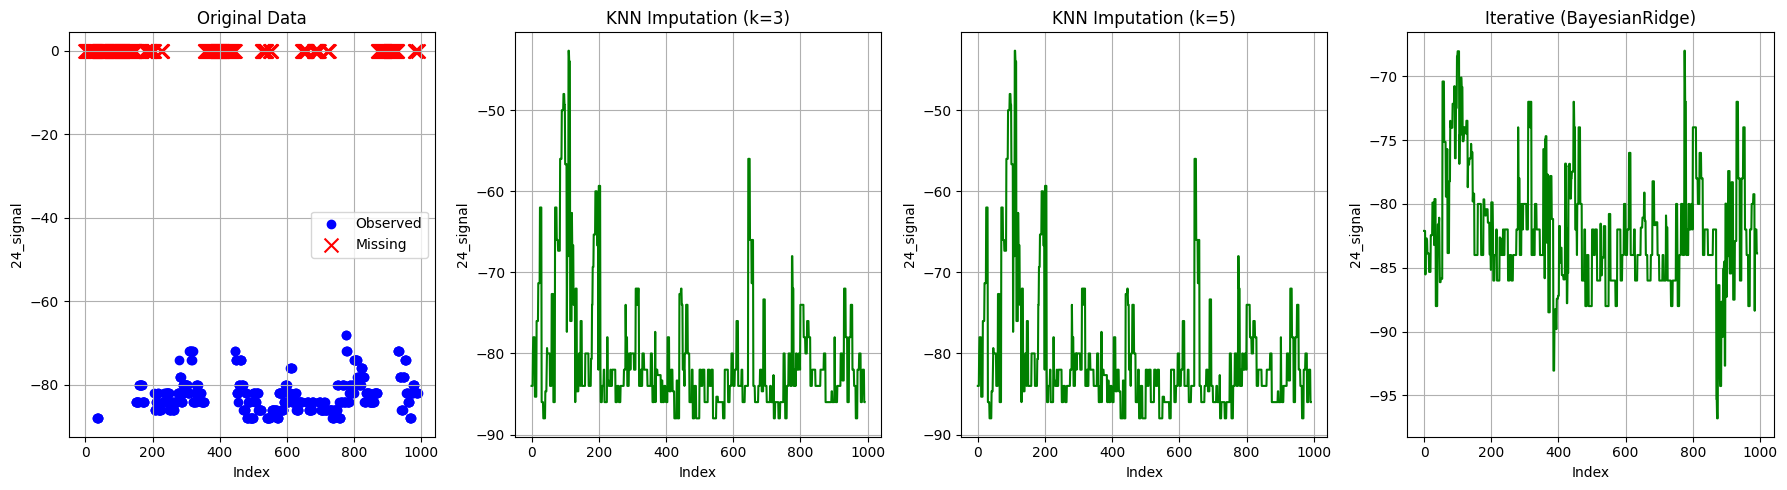

In [16]:
# Select a sample column to visualize (first signal column)
sample_column = signal_cols[0]

# Get the first half of the data set
half_index = len(dff_filtered) // 2
original_half = dff_filtered.iloc[:half_index]
missing_mask = original_half[sample_column].isnull()

plt.figure(figsize=(18, 5))

# Orijinal data
plt.subplot(1, 4, 1)
plt.scatter(original_half.index[~missing_mask], original_half[sample_column][~missing_mask],
            color='blue', label='Observed')
plt.scatter(original_half.index[missing_mask], [0]*missing_mask.sum(),
            color='red', marker='x', s=100, label='Missing')
plt.title("Original Data")
plt.xlabel("Index")
plt.ylabel(sample_column)
plt.legend()
plt.grid()
for i, (method_name, imputed_df) in enumerate(imputed_results.items(), start=2):
    plt.subplot(1, 4, i)
    imputed_half = imputed_df.iloc[:half_index]
    plt.plot(imputed_half.index, imputed_half[sample_column], color='green', label='Imputed')
    plt.title(method_name)
    plt.xlabel("Index")
    plt.ylabel(sample_column)
    plt.grid()

plt.tight_layout()
plt.show()

In [17]:
signal_cols = [col for col in dff_filtered.columns if col.endswith('_signal')]
iterative_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)

dff_filtered[signal_cols] = pd.DataFrame(
    iterative_imputer.fit_transform(dff_filtered[signal_cols]),
    columns=signal_cols,
    index=dff_filtered.index
)
print("filled data with iterative_imputer")
print(dff_filtered[signal_cols].isnull().sum())

filled data with iterative_imputer
24_signal    0
31_signal    0
34_signal    0
35_signal    0
36_signal    0
37_signal    0
42_signal    0
43_signal    0
44_signal    0
45_signal    0
48_signal    0
49_signal    0
52_signal    0
53_signal    0
68_signal    0
69_signal    0
72_signal    0
73_signal    0
76_signal    0
77_signal    0
78_signal    0
79_signal    0
97_signal    0
dtype: int64


In [18]:
# Create the StandardScaler object
scaler = StandardScaler()
dff_filtered[signal_cols] = pd.DataFrame(scaler.fit_transform(dff_filtered[signal_cols]),columns=signal_cols,index=dff_filtered.index)

# Feature Importance

In [19]:
def calculate_feature_importance(dataframe, signal_columns, target_column, n_estimators=100, random_state=42):
    # Separate x and y
    X = dataframe[signal_columns]
    y = dataframe[target_column]
    
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)
    
    # Get feature highlights
    importances = rf.feature_importances_
    
    # Return as a DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': signal_columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    return feature_importance_df

In [20]:
def plot_feature_importance_with_table(feature_importance_df, top_n=20,
                                       title="Özellik Önem Sıralaması", xlabel="Özellik Önemi",
                                       ylabel="Sinyal Özelliği", palette="crest"):

    # Get the ordered data and reset the index
    df_top = feature_importance_df.head(top_n).reset_index(drop=True)

    # Create Figure and 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [2.5, 1]})
    sns.set_style("whitegrid")

    # --- Left: Barplot ---
    sns.barplot(
        x='Importance',
        y='Feature',
        hue='Feature',
        data=df_top,
        palette=palette,
        dodge=False,
        legend=False,
        ax=axes[0]
    )

    axes[0].set_title(title, fontsize=16, weight='bold')
    axes[0].set_xlabel(xlabel, fontsize=13)
    axes[0].set_ylabel(ylabel, fontsize=13)

    for index, value in enumerate(df_top['Importance']):
        axes[0].text(value + 0.0005, index, f"{value:.4f}", va='center', fontsize=9)

    # --- Right: Tablo ---
    axes[1].axis('off')  # Eksenleri gizle

    table_data = df_top.round(4).values.tolist()
    column_labels = df_top.columns.tolist()

    table = axes[1].table(cellText=table_data,
                          colLabels=column_labels,
                          cellLoc='center',
                          loc='center',
                          colWidths=[0.4, 0.3])  # Column widths

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.3, 2.1)  # Width, Height ratio

    # Header stilleri ve alternating row colors
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4C72B0')
        else:
            cell.set_facecolor('#f9f9f9') if row % 2 == 0 else cell.set_facecolor('#ffffff')
        cell.set_edgecolor('#dddddd')

    plt.subplots_adjust(wspace=0.05)  # İki subplot arası boşluk
    plt.show()

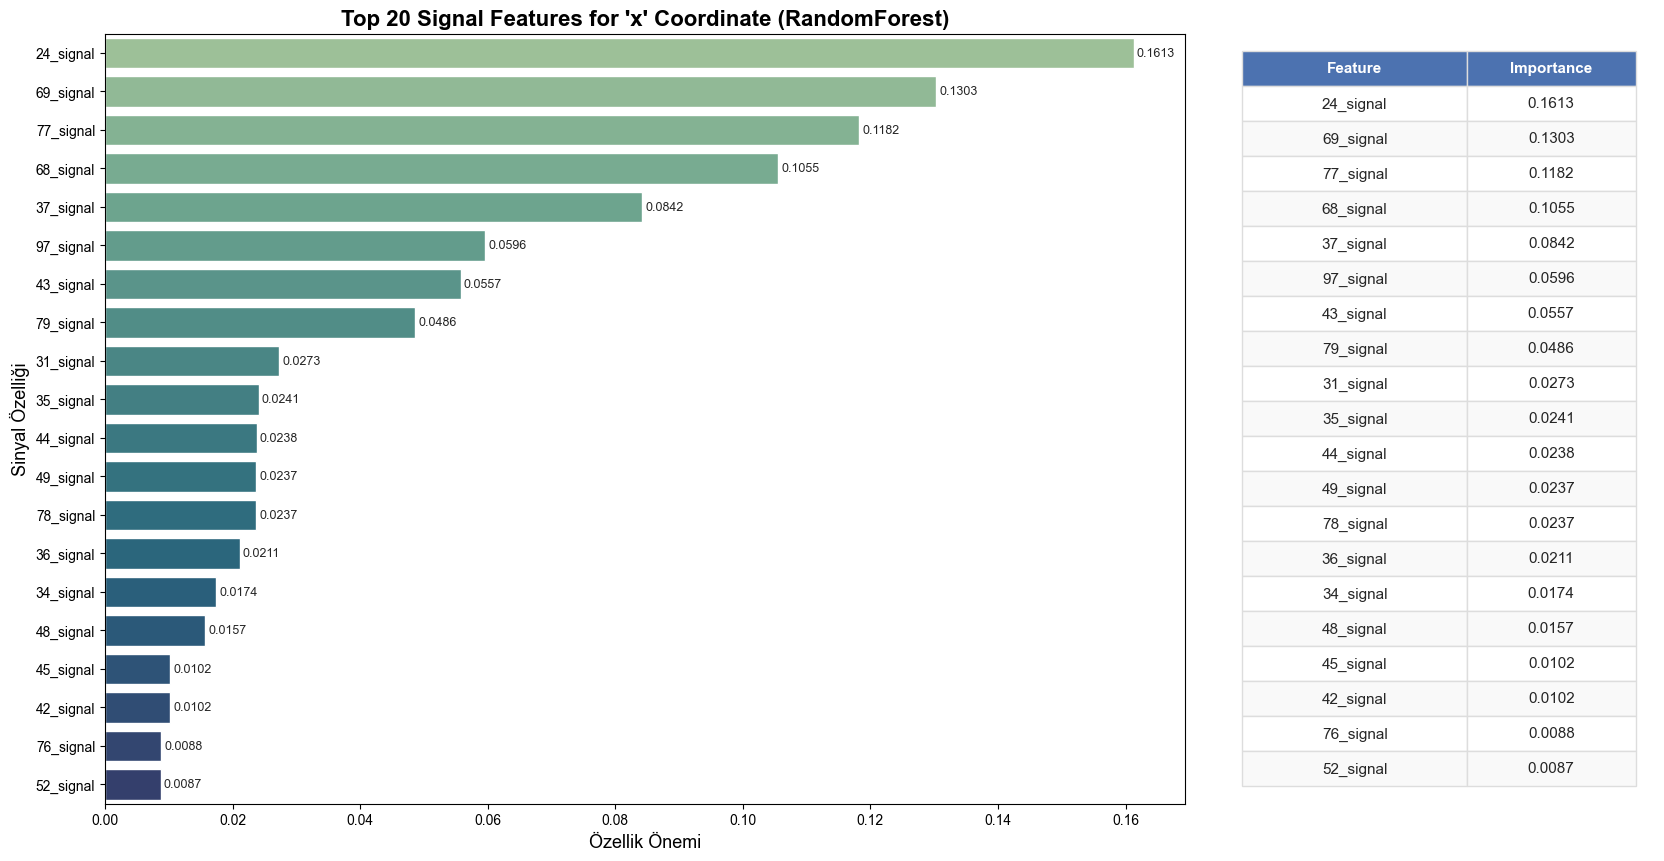

In [21]:
feature_importance_df = calculate_feature_importance(dff_filtered, signal_cols, target_column="x")
plot_feature_importance_with_table(feature_importance_df, top_n=20,
                                   title="Top 20 Signal Features for 'x' Coordinate (RandomForest)")

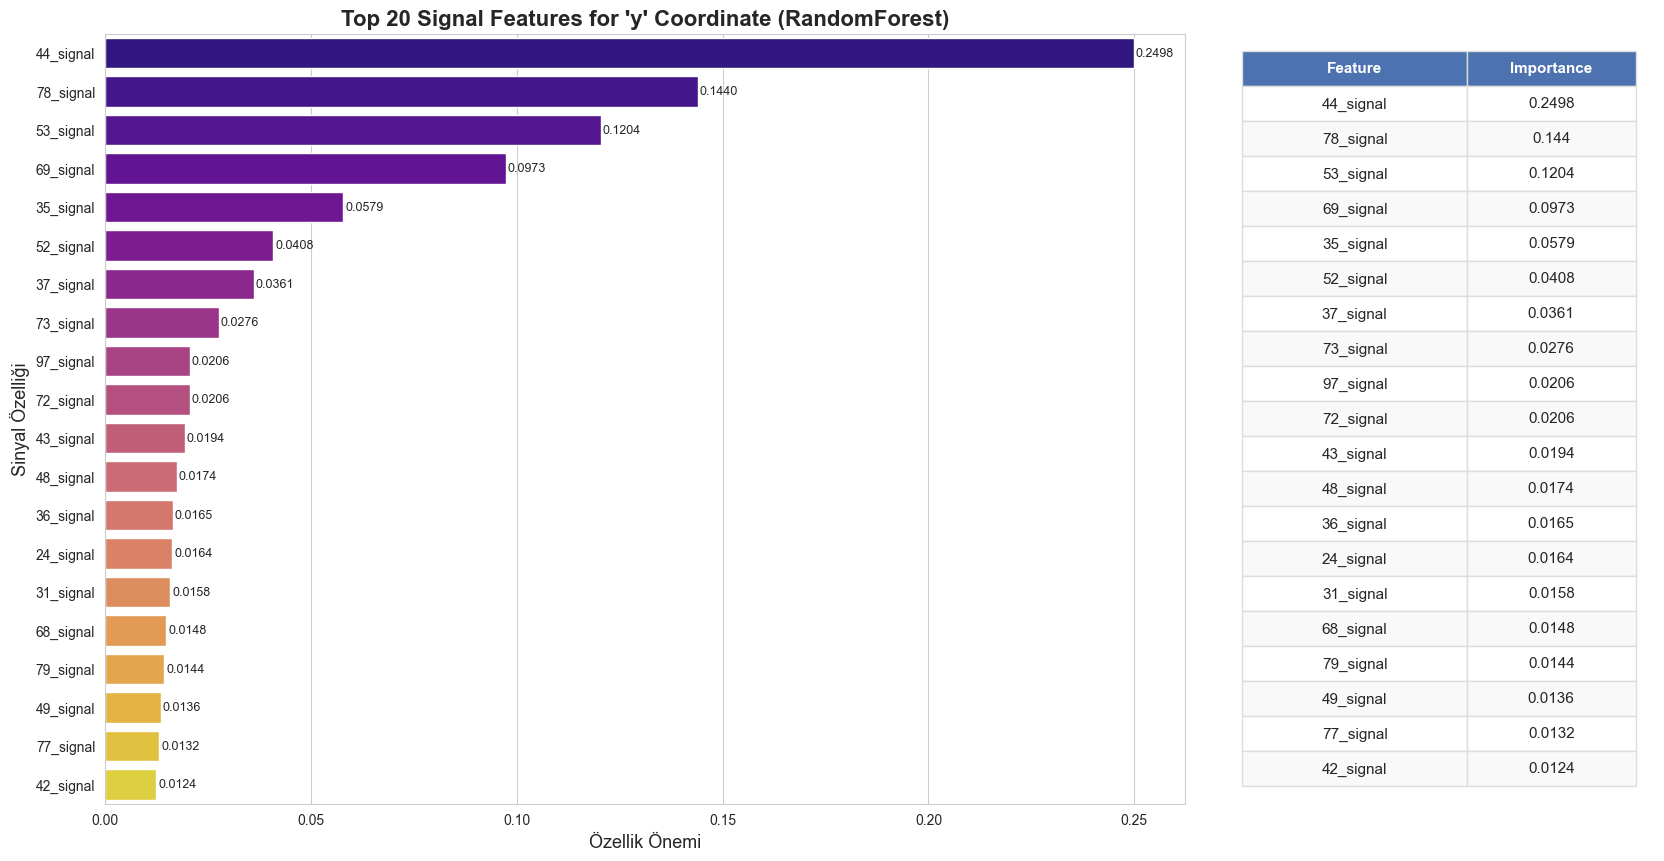

In [22]:
feature_importance_df = calculate_feature_importance(dff_filtered, signal_cols, target_column="y")
plot_feature_importance_with_table(feature_importance_df, top_n=20,
                                   title="Top 20 Signal Features for 'y' Coordinate (RandomForest)",palette="plasma")

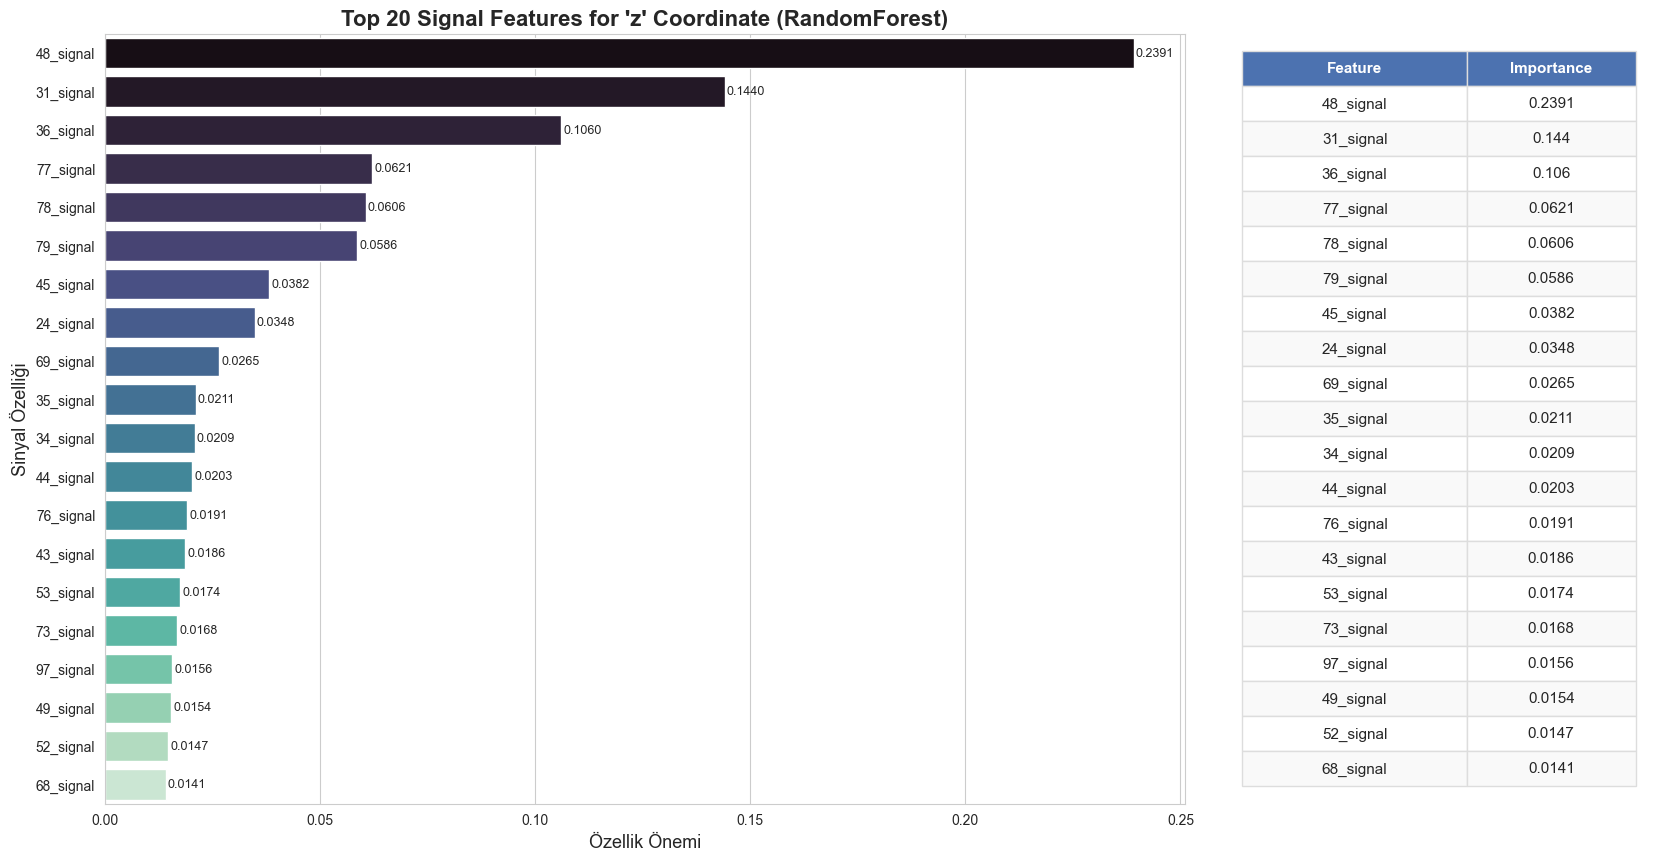

In [23]:
feature_importance_df = calculate_feature_importance(dff_filtered, signal_cols, target_column="z")
plot_feature_importance_with_table(feature_importance_df, top_n=20,
                                   title="Top 20 Signal Features for 'z' Coordinate (RandomForest)",palette="mako")

# Machine Learning ,Evalution & Model Selection

In [24]:
def mean_euclidean_distance(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

In [25]:
def base_regression_models(X, targets):
    print("Base Regression Models Evaluation...")
    models = {
        "lr": LinearRegression(),
        "knn": KNeighborsRegressor(),
        "rf": RandomForestRegressor(random_state=42),
        "xgb": XGBRegressor(random_state=42)
    }

    for name, model in models.items():
        all_preds = []
        all_trues = []
        for coord in ['x', 'y', 'z']:
            X_train, X_test, y_train, y_test = train_test_split(
                X, targets[coord], test_size=0.3, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            all_preds.append(y_pred)
            all_trues.append(y_test.values)

        y_test_combined = np.vstack(all_trues).T
        y_pred_combined = np.vstack(all_preds).T

        dist = mean_euclidean_distance(y_test_combined, y_pred_combined)
        print(f"📏 Mean Euclidean Distance ({name.upper()}): {dist:.4f}")

In [26]:
X = dff_filtered.drop(columns=['x', 'y', 'z'])
X = dff_filtered[[col for col in dff_filtered.columns if col.endswith("_signal")]]
targets = dff_filtered[['x', 'y', 'z']]
base_regression_models(X, targets)

Base Regression Models Evaluation...
📏 Mean Euclidean Distance (LR): 11.2974
📏 Mean Euclidean Distance (KNN): 2.7557
📏 Mean Euclidean Distance (RF): 1.3359
📏 Mean Euclidean Distance (XGB): 0.5557


In [29]:
def optimize_regressors(X, targets):
    print("\nHyperparameter Optimization...")
    best_models = {}
    distances = {}

    param_grids = {
        "knn": {"n_neighbors": range(2, 21),"weights": ["uniform", "distance"],"p": [1, 2]},
        "rf": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False]
        },
        "xgb": {
            "n_estimators": [100, 200,300],
            "learning_rate": [0.01, 0.05,0,1],
            "max_depth": [3, 5, 7, 10],
            "subsample": [0.7, 0.8, 1.0],
            "colsample_bytree": [0.7, 0.8, 1.0]
        }
    }

    for name, model in [("knn", KNeighborsRegressor()),
                        ("rf", RandomForestRegressor(random_state=42)),
                        ("xgb", XGBRegressor(random_state=42))]:
        all_preds = []
        all_trues = []
        for coord in ['x', 'y', 'z']:
            X_train, X_test, y_train, y_test = train_test_split(
                X, targets[coord], test_size=0.3, random_state=42)

            grid = GridSearchCV(model, param_grids[name], cv=3, n_jobs=-1).fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"{name.upper()} best params for {coord.upper()}: {grid.best_params_}")
            y_pred = best_model.predict(X_test)

            all_preds.append(y_pred)
            all_trues.append(y_test.values)

        y_test_combined = np.vstack(all_trues).T
        y_pred_combined = np.vstack(all_preds).T

        dist = mean_euclidean_distance(y_test_combined, y_pred_combined)
        distances[name.upper()] = dist
        print(f"📏 Optimized {name.upper()} Mean Euclidean Distance: {dist:.4f}\n")
        best_models[name] = best_model

    return best_models,distances

In [30]:
# 2. Hyperparameter optimization
best_models, opt_distances = optimize_regressors(X, targets)


Hyperparameter Optimization...
KNN best params for X: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
KNN best params for Y: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
KNN best params for Z: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
📏 Optimized KNN Mean Euclidean Distance: 0.2932

RF best params for X: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RF best params for Y: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
RF best params for Z: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
📏 Optimized RF Mean Euclidean Distance: 1.3111

XGB best params for X: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
XGB best params for Y: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
XGB best params f

# Visualize All Tried Results

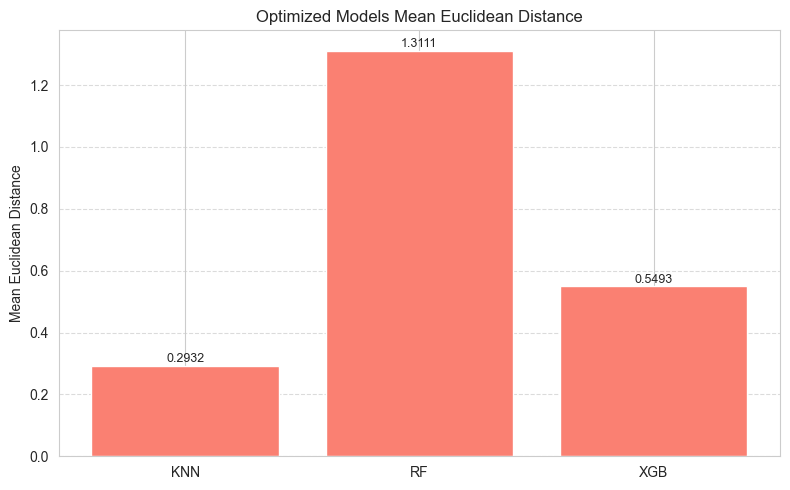

In [31]:
def plot_model_distances(distances, title="Model Performance Comparison", color="cornflowerblue"):
    plt.figure(figsize=(8, 5))
    model_names = list(distances.keys())
    distance_values = list(distances.values())

    bars = plt.bar(model_names, distance_values, color=color)
    plt.ylabel("Mean Euclidean Distance")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Her çubuğun üzerine değeri yaz
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.001, f"{height:.4f}",
                 ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()
plot_model_distances(opt_distances, title="Optimized Models Mean Euclidean Distance", color="salmon")    

In [73]:
def train_and_show_best_knn(X, targets):
    print("🎯 Training KNN with Best Hyperparameters...\n" + "="*40)

    param_grid = {
        "n_neighbors": range(2, 21),
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    }

    knn = KNeighborsRegressor(metric="euclidean")
    grid_search = GridSearchCV(knn, param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X, targets)
    
    best_knn = grid_search.best_estimator_
    print(f"\nBest KNN Parameters: {grid_search.best_params_}")

    X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.3, random_state=42)
    best_knn.fit(X_train, y_train)
    y_pred = best_knn.predict(X_test)
    print("\nBest KNN Model Parameters after training:")
    print(best_knn.get_params())

In [74]:
X = dff_filtered.drop(columns=['x', 'y', 'z'])
X = dff_filtered[[col for col in dff_filtered.columns if col.endswith("_signal")]]
targets = dff_filtered[['x', 'y', 'z']]
train_and_show_best_knn(X, targets)

🎯 Training KNN with Best Hyperparameters...

Best KNN Parameters: {'n_neighbors': 19, 'p': 1, 'weights': 'distance'}

Best KNN Model Parameters after training:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}


In [75]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_predictions(true_coords, pred_coords, n_samples=100):
    fig = plt.figure(figsize=(12, 6))

    # create subplot
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Choose a random sample
    indices = np.random.choice(len(true_coords), min(n_samples, len(true_coords)), replace=False)

    true_sample = true_coords[indices]
    pred_sample = pred_coords[indices]

    # Actual Coordinates
    ax1.scatter(true_sample[:, 0], true_sample[:, 1], true_sample[:, 2], c='green', marker='o', label='True')
    ax1.set_title("The Actual Coordinates")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    # The Predicted Coordinates
    ax2.scatter(pred_sample[:, 0], pred_sample[:, 1], pred_sample[:, 2], c='red', marker='^', label='Predicted')
    ax2.set_title("The Predicted Coordinates")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    plt.tight_layout()
    plt.show()

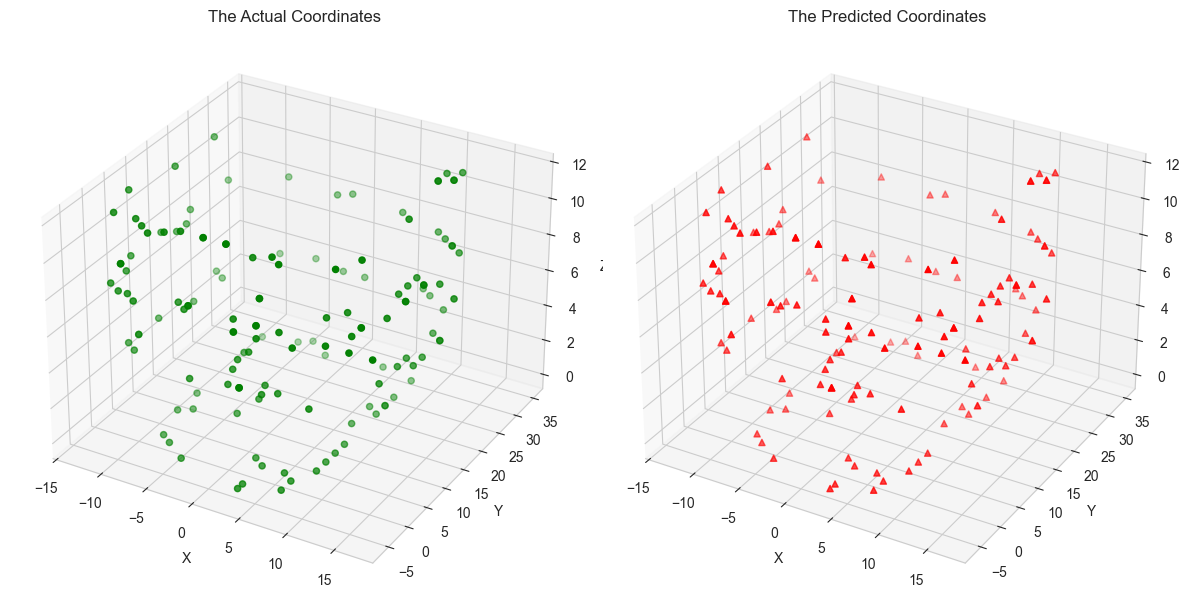

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.3, random_state=42)
true_coords, pred_coords = train_and_predict_all_coords(best_models["knn"], X_train, X_test, y_train, y_test)
plot_3d_predictions(true_coords, pred_coords, n_samples=150)

# Saving The Model

In [77]:
import joblib
joblib.dump(best_knn_model, "best_knn_model.pkl")
print("The model was successfully registered: best_knn_model.pkl")

The model was successfully registered: best_knn_model.pkl


# Model Deployment

In [79]:
loaded_knn = joblib.load("best_knn_model.pkl")
print("📦 Model başarıyla yüklendi.")

📦 Model başarıyla yüklendi.


# Testing With Test Data#Showing Predictions

In [80]:
example_input = X_test.iloc[0:1]
prediction = loaded_knn.predict(example_input)

print(" Tahmin (x, y, z):", prediction[0])

 Tahmin (x, y, z): 4.0
